In [4]:
import numpy as np
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt

In [5]:
scale = 0.25
filter_bg = False
orig_feat = pl.read_csv(f"/home/surayuth/her2/extracted_features/orig_feat_level_16_white_balance_False_scale_{scale}.csv")
persist_feat = pl.read_csv(f"/home/surayuth/her2/extracted_features/persist_feat_remove_noise_False_white_balance_False_filter_bg_{filter_bg}_scale_0.25.csv")

In [6]:
persist_feat = persist_feat \
    .with_columns(
        pl.Series(
            [Path(p).stem for p in persist_feat["path"].to_list()]
        ).alias("stem")
    )

orig_feat = orig_feat \
    .with_columns(
        pl.Series(
            [Path(p).stem for p in orig_feat["path"].to_list()]
        ).alias("stem")
    )

combined_feat = orig_feat.drop("ihc_score", "label") \
    .join(
        persist_feat.drop("path"),
        on=["case", "stem"],
        how="inner"
    ).drop("stem")

In [7]:
combined_feat.write_csv(f"../extracted_features/combined_feat_scale_{scale}_filter_bg_{filter_bg}.csv")

In [23]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

X = persist_feat.drop("path", "case", "ihc_score", "label", "stem").to_numpy()
y = persist_feat.select("label").to_numpy().reshape(-1)

estimator = SVR(kernel="linear")

selector = RFE(estimator, n_features_to_select=2, step=1)

selector = selector.fit(X, y)

selector.support_

array([False, False, False, False, False, False,  True,  True, False,
       False])

In [24]:
np.array(persist_feat.drop("path", "case", "ihc_score", "label", "stem").columns)[selector.support_]

array(['mean', 'std'], dtype='<U8')

In [36]:
agg = persist_feat.select("path", "case", "mean", "std", "label") \
    .group_by("case") \
    .agg(
        pl.col("mean").mean(),
        pl.col("std").mean(),
        pl.col("label").first()
    ) \
    .sort("label", "mean") 

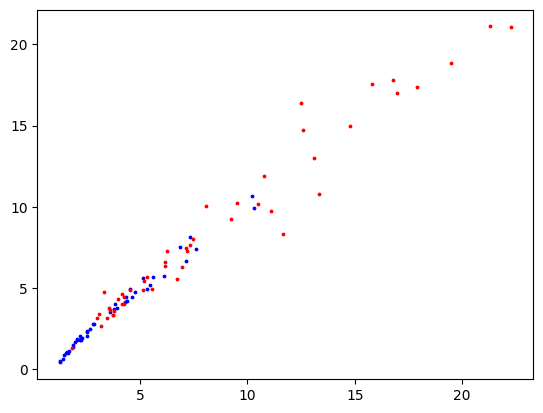

In [45]:
plt.scatter(agg.filter(pl.col("label") == 0).select("mean"), agg.filter(pl.col("label") == 0).select("std"), s=3, c="b")
plt.scatter(agg.filter(pl.col("label") == 1).select("mean"), agg.filter(pl.col("label") == 1).select("std"), s=3, c="r")

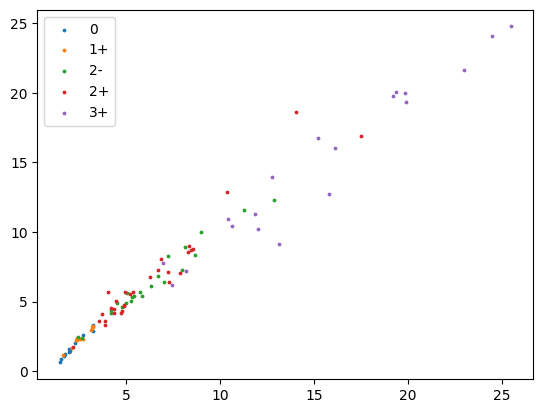

In [91]:
agg2 = persist_feat.select("path", "case", "mean", "std", "label", "ihc_score") \
    .sort("case", "mean", descending=[False, True]) \
    .with_columns(
        pl.arange(1, pl.len() + 1).over("case")
        .alias("idx"),
        pl.len().over('case').alias("len")
    ) \
    .with_columns(
        (pl.col("idx") / pl.col("len")).alias("p")
    ) \
    .filter(
        pl.col("p") <= 0.5
    ) \
    .group_by("case") \
    .agg(
        pl.col("mean").mean(),
        pl.col("std").mean(),
        pl.col("label").first(),
        pl.col("ihc_score").first()
    ) \
    .sort("label", "mean")

fig, ax = plt.subplots()
for score in ["0", "1+", "2-", "2+", "3+"]:
    sub_agg = agg2.filter(pl.col("ihc_score") == score)
    x = sub_agg.select("mean")
    y = sub_agg.select("std")
    ax.scatter(x, y, label=score, s=3)
ax.legend()